# Fluorescence intensity detection and identification system

Using OpenCV to detect fluorescence intensity which emulates SYBR Green fluorescence from multiple color jpeg images. Data is ~~parsed from HTTP POST requests by ESP32-CAM with OV2640 sensor~~ received from Raspberry Pi Camera Module v1.3, epmloying an OV5647 5MP CMOS sensor, integrated using [LCCV](https://github.com/kbarni/lccv.git) and OpenCV.

In [6]:
# import os
# os.environ['QT_QPA_PLATFORM'] = 'xcb'

import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

G-channel extraction to enhance sensitivity on green emission variance.

In [7]:
def extract_g_channel(bgr_image):
    """
    Extract the G (green) channel from a BGR image and return it as a grayscale image.
    
    Parameters:
        bgr_image: Input BGR image (numpy array from cv.imread())
    
    Returns:
        g_channel: Single-channel grayscale image containing only the green channel data
    """

    g_channel = bgr_image[:, :, 1]

    return g_channel

## 1. Test ambient noise by getting a background image of the scene

Get background image

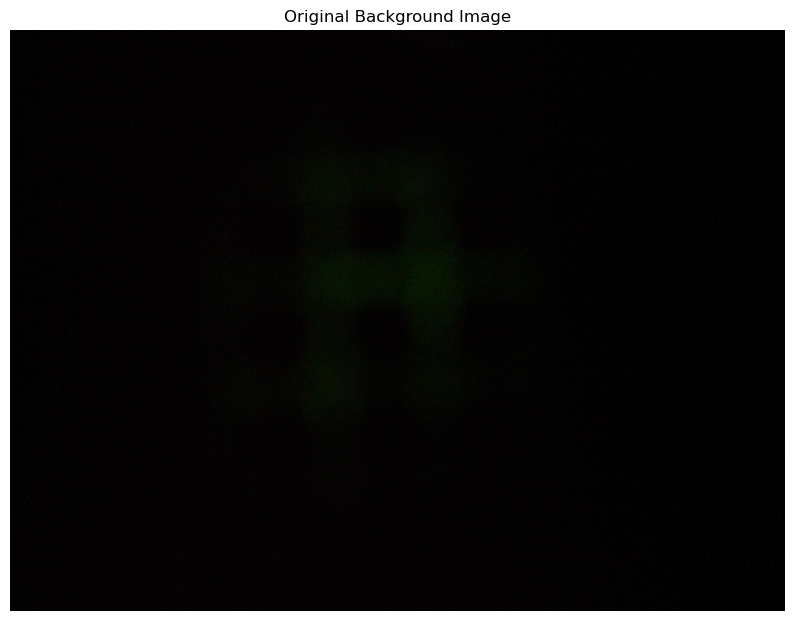

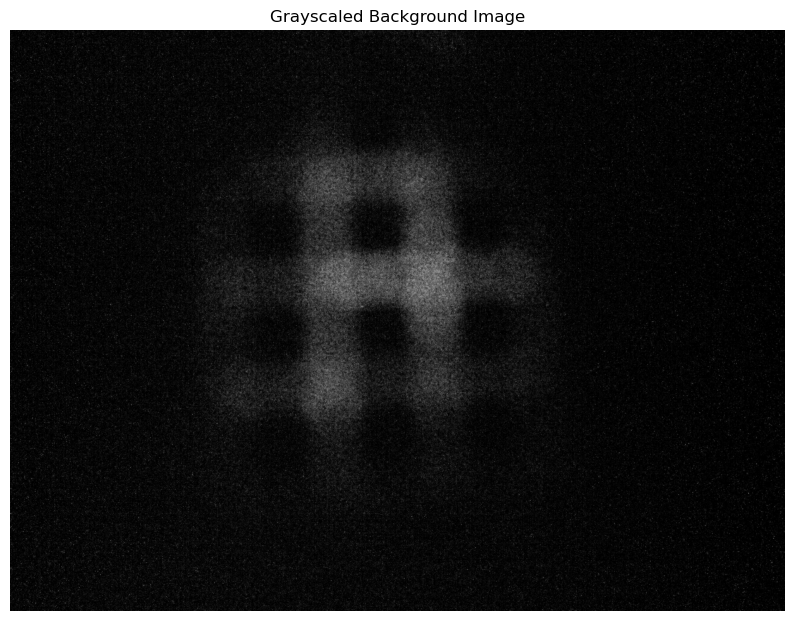

In [ ]:
img = cv.imread('../AwbOff470/img_full_bg.jpg')
# gray1 = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
gray1 = extract_g_channel(img)

plt.figure(figsize=(10, 8))
plt.imshow(img)
plt.title('Original Background Image')
plt.axis('off')
plt.show()

plt.figure(figsize=(10, 8))
plt.imshow(gray1, cmap='gray')
plt.title('Grayscaled Background Image')
plt.axis('off')
plt.show()

Average all pixels in the image and print out the ~~8-bit value~~ 32-bit floating point values.

## 1.5 Gamma-compressed data recovery

Before that, let's try to use gamma decoding to recover a mathematical estimate of the OV5647 CMOS sensor's Bayer raw data. We do this by converting the 8U matrices into 32F to hold precise, normalized, gamma-decoded pixel values. We apply normalization as well just so the values do not explode after decoding.

$$I_{linear} = \left( \frac{I_{pixel}}{255} \right)^{\gamma}$$

$I_{pixel}$: Measured 0-255 pixel intensity from LCCV.

$\gamma$: Gamma curve constant ($\gamma > 1$ for [gamma decoding](https://en.wikipedia.org/wiki/Gamma_correction)). Note: We can try out multiple values to get the perfect shape of the amplification graph.

$I_{linear}$: The normalized (0.0 to 1.0) value proportional to actual photons (Lux).

$\textcolor{orange}{\textbf{Note}}$: The resulting values will only be approximation of the raw data and not the actual, non-aliased pixel values because LCCV, through ```lccv::getVideoFrame()``` API, not only gamma-encoded the data, but also quantized them into 8-bit unsigned integers.

There are two ways to achieve the best gamma curve approximation:

1. Sweep the gamma curve to get the most desired shape.

2. Using reference graph to get the "ideal" pixel values where gamma-compressed data are recovered with as little aliasing as possible. The graph must take the weakest fluorescence value as an input, then calculate the logarithmic curve upwards because in a gamma-compressed stream processed by the camera pipeline, the highest of pixel values are the ones most significantly and noticeably attenuated to fit in the smaller memory size.

Either way, both methods need a reference graph either for mere comparison or for the gamma curve calculation itself. For the case of the second appoach, after the graph is calculated, the highest value calculated by the graph, $I_{ref, max}$, and the MSA output of the strongest fluorescence, $I_{pixel, max}$, should be the points of gamma curve calculation, wherein

$$\gamma = \log_{I_{pixel, max}}(I_{ref, max})$$

### Calculate reference graph

When calculating for reference graph with the objective of finding out the best approximation to the value of gamma curve ($\gamma$), one needs to keep in mind that non-linear operations such as gamma correction and gamma decoding must precede linear calculations (e.g., image background subtraction) where otherwise would be mathematically illegal as they are not algebraic associative.

$$A^{\gamma} - B^{\gamma} \not= (A - B)^{\gamma}$$

$A$: Fluorescence-containing, unrecovered data frame.

$B$: Background (unrecovered) data frame.

$\textcolor{orange}{\textbf{Note}}$: It is generally more favorable to calculate gamma curve without any background subtraction step as it is unnecessary and may introduce easily-preventable errors.

In [ ]:
def linearizeImageFrame(imageG):
    """
    Apply gamma linearization to the input image frame.
    
    Parameters:
        imageG: Input image (numpy array) after G-extraction (grayscale)
    
    Returns:
        linearized_image: Linearized image (numpy array)
    """
    img_min = 0
    img_max = 255
    normalized_image = (imageG.astype(np.float32) - img_min) / (img_max - img_min)
    linearized_image = np.power(normalized_image, 2.2)

    return linearized_image

Function to calculate the reference fluorescnce graph. This function is general-purpose, meaning it can be used to calculate a reference list for any of the two methods.

In [26]:
def calculateReferenceFluorescenceGraph(weakest_value, num_samples):
    '''
    Calculating sample fluorescence (sodium fluorescein) graph as an ideal reference.

    Parameters:
        weakest_value: Single MSA output of the weakest fluorescence sample.
        num_samples: Total number of samples or time points (e.g., 8 for total of 8 time points).

    Returns:
        reference_list: List of calculated reference fluorescence values for each sample/time point.
    '''
    reference_list = np.zeros(num_samples)
    for i in range(num_samples):
        reference_list[num_samples - 1 - i] = weakest_value * (2 ** i)
    return reference_list

### Define MSA (Maximum Section Averages) and SSA (Static Section Averages) algorithms

Overall average pixel value: 2.77

Image dimensions: 2592 x 1944
Section size: 648 x 648
\Sectioned image analysis:
Min section average: 1.10
Max section average: 5.70
Standard deviation across sections: 1.35


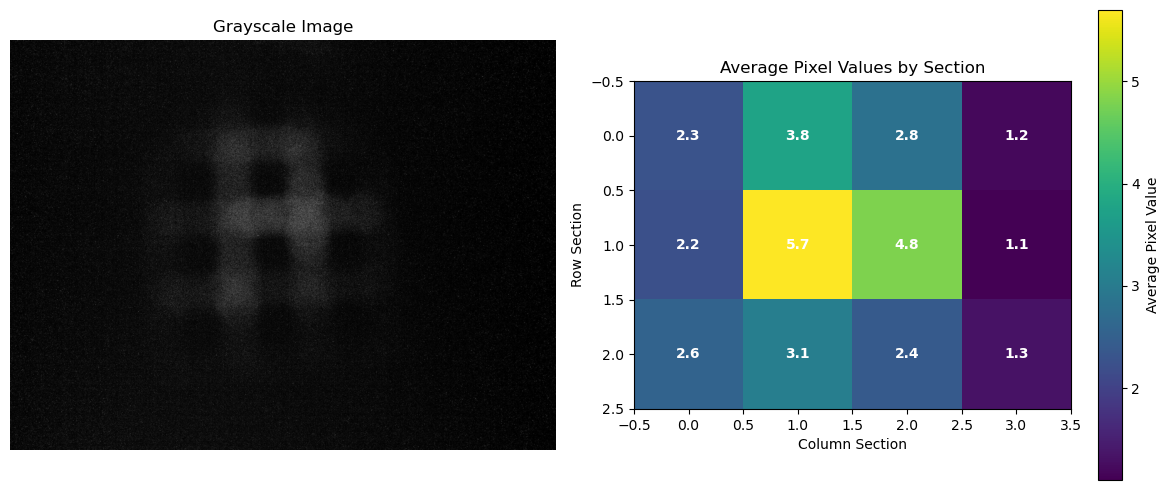

In [21]:
# Convert to grayscale for noise analysis
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
# gray = extract_g_channel(img)
# gray = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)

def pixel_average_analysis(gray, section_rows=3, section_cols=4, static_row=None, static_col=None, verbose=True):
    if static_row is not None and static_col is not None:
        if static_row >= section_rows or static_col >= section_cols:
            raise ValueError("static_row and static_col must be within the range of section_rows and section_cols respectively.")
    # Calculate overall average
    overall_avg = np.mean(gray)
    if verbose:
        print(f"Overall average pixel value: {overall_avg:.2f}")

    # Divide image into sections
    height, width = gray.shape
    section_rows = section_rows
    section_cols = section_cols

    row_size = height // section_rows
    col_size = width // section_cols

    if verbose:
        print(f"\nImage dimensions: {width} x {height}")
        print(f"Section size: {col_size} x {row_size}")
    # print("\nAverage pixel values by section:")

    # Create a matrix to store section averages
    section_averages = np.zeros((section_rows, section_cols))

    for i in range(section_rows):
        for j in range(section_cols):
            # Calculate section boundaries
            start_row = i * row_size
            end_row = (i + 1) * row_size if i < section_rows - 1 else height
            start_col = j * col_size
            end_col = (j + 1) * col_size if j < section_cols - 1 else width
            
            # Extract section
            section = gray[start_row:end_row, start_col:end_col]
            
            # Calculate average for this section
            section_avg = np.mean(section)
            section_averages[i, j] = section_avg
            
            # print(f"Section [{i+1},{j+1}]: {section_avg:.2f}")

    # Display statistics
    if verbose:
        print(f"\Sectioned image analysis:")
        print(f"Min section average: {np.min(section_averages):.2f}")
        print(f"Max section average: {np.max(section_averages):.2f}")
        print(f"Standard deviation across sections: {np.std(section_averages):.2f}")

    # Visualize the section averages as a heatmap
    if verbose:
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.imshow(gray, cmap='gray')
        plt.title('Grayscale Image')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(section_averages, cmap='viridis', interpolation='nearest')
        plt.title('Average Pixel Values by Section')
        plt.colorbar(label='Average Pixel Value')
        plt.xlabel('Column Section')
        plt.ylabel('Row Section')

        # Add text annotations to show values
        for i in range(section_rows):
            for j in range(section_cols):
                plt.text(j, i, f'{section_averages[i,j]:.1f}', 
                        ha='center', va='center', color='white', fontweight='bold')

        plt.tight_layout()
        
        plt.show()

    return overall_avg, np.max(section_averages), np.min(section_averages), section_averages[static_row, static_col] if static_row is not None and static_col is not None else None

avgg, maxg, _, _ = pixel_average_analysis(gray, section_rows=3, section_cols=4)

Image has background noise. Background will be subtracted from fluorescence image.

In [22]:
background_model = gray.copy().astype(np.float32)

def subtract_background(image, background):
    # Ensure both are float32 for proper subtraction
    img_float = image.astype(np.float32)
    bg_float = background.astype(np.float32)
    
    # Subtract background and clip to valid range
    result = np.clip(img_float - bg_float, 0, 255)
    return result.astype(np.uint8)

## 2. Image segmentation to focus on ROI

Overall average pixel value: 31.48

Image dimensions: 2592 x 1944
Section size: 324 x 324
\Sectioned image analysis:
Min section average: 1.59
Max section average: 244.58
Standard deviation across sections: 63.11


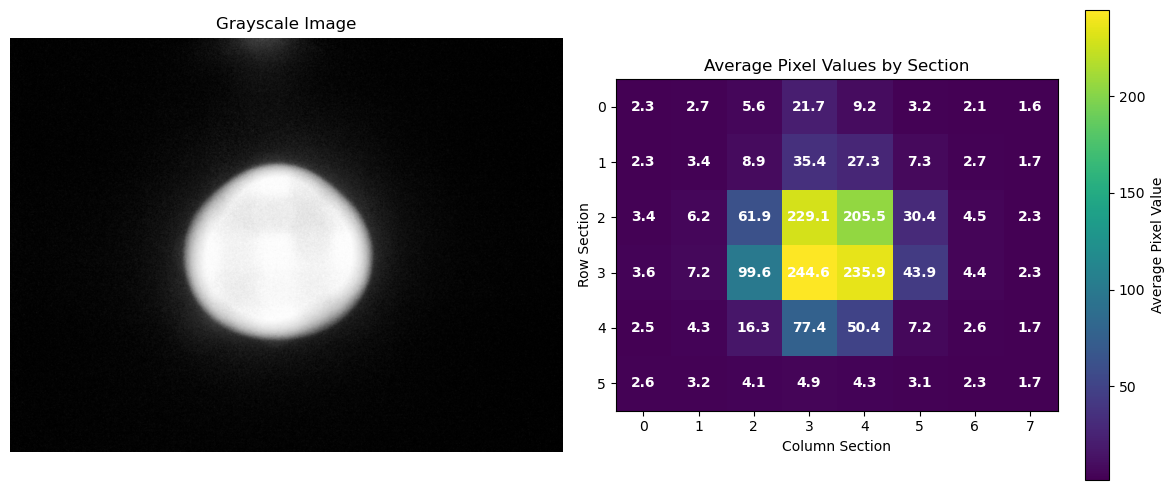

(np.float64(31.478768162881675),
 np.float64(244.5819996951684),
 np.float64(1.5855719402530102),
 None)

In [ ]:
fluo = cv.imread('../AwbOff470/img_full_0000.jpg')
# plt.figure(figsize=(10, 8))
# plt.imshow(fluo)
# plt.title('Original Fluorescence Image')
# plt.axis('off')
# plt.show()
# fluog = cv.cvtColor(fluo, cv.COLOR_BGR2GRAY)
fluog = extract_g_channel(fluo)
# plt.figure(figsize=(10, 8))
# plt.imshow(fluog, cmap='gray')
# plt.title('Grayscaled Fluorescence Image')
# plt.axis('off')
# plt.show()

suback_fluog = subtract_background(fluog, background_model)
# plt.figure(figsize=(10, 8))
# plt.imshow(suback_fluog, cmap='gray')
# plt.title('Subtracted Fluorescence Image')
# plt.axis('off')
# plt.show()

pixel_average_analysis(suback_fluog, section_rows=6, section_cols=8)

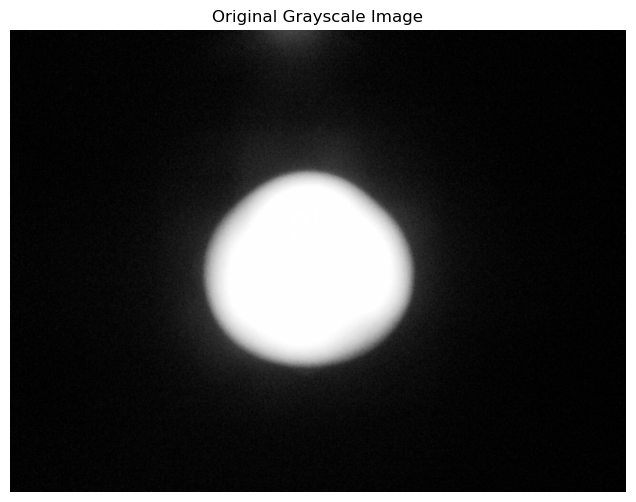

In [9]:
plt.figure(figsize=(8, 6))
plt.imshow(fluog, cmap='gray')
plt.title('Original Grayscale Image')
plt.axis('off')
plt.show()

In [10]:
def get_roi(fluo, suback_fluog, threshold_value=8, verbose=True):
    # Pixels brighter than 8 will become white (255), others black (0).
    threshold_value = threshold_value
    _, mask = cv.threshold(suback_fluog, threshold_value, 255, cv.THRESH_BINARY)

    contours, _ = cv.findContours(mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

    if contours:
        # Find the largest contour by area
        largest_contour = max(contours, key=cv.contourArea)

        x, y, w, h = cv.boundingRect(largest_contour)
        cv.rectangle(fluo, (x, y), (x+w, y+h), (0, 0, 255), 2)

        if verbose:
            print(f"Found object with bounding box: x={x}, y={y}, width={w}, height={h}")
    else:
        if verbose:
            print("No object found meeting the threshold criteria.")

    if verbose:
        plt.figure(figsize=(15, 5))

        # Original image with ROI marked
        plt.subplot(1, 3, 1)
        plt.imshow(cv.cvtColor(fluo, cv.COLOR_BGR2RGB))  # Convert BGR to RGB for proper display
        plt.title('Original Image with ROI Marked')
        plt.axis('off')

        # Grayscale image
        plt.subplot(1, 3, 2)
        plt.imshow(suback_fluog, cmap='gray')
        plt.title('Subtracted Grayscale Image')
        plt.axis('off')

        # Mask from thresholding
        plt.subplot(1, 3, 3)
        plt.imshow(mask, cmap='gray')
        plt.title('Mask from Thresholding')
        plt.axis('off')

        plt.tight_layout()
        plt.show()

    return x, y, w, h


Found object with bounding box: x=617, y=0, width=1259, height=1579


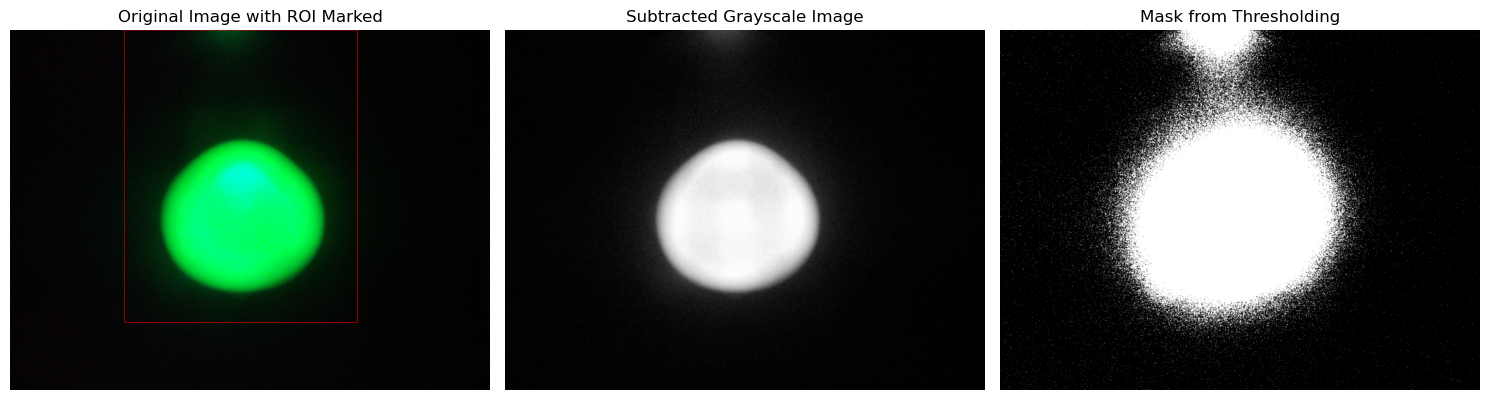

In [11]:

x, y, w, h = get_roi(fluo, suback_fluog, threshold_value=14)


Overall average pixel value: 31.48

Image dimensions: 2592 x 1944
ROI area: Row: 617:1876, Column: 0:1579
ROI size: 1259 x 1579
\Pixel analysis:
Average pixel value at ROI: 110.08
Standard deviation at ROI: 104.94


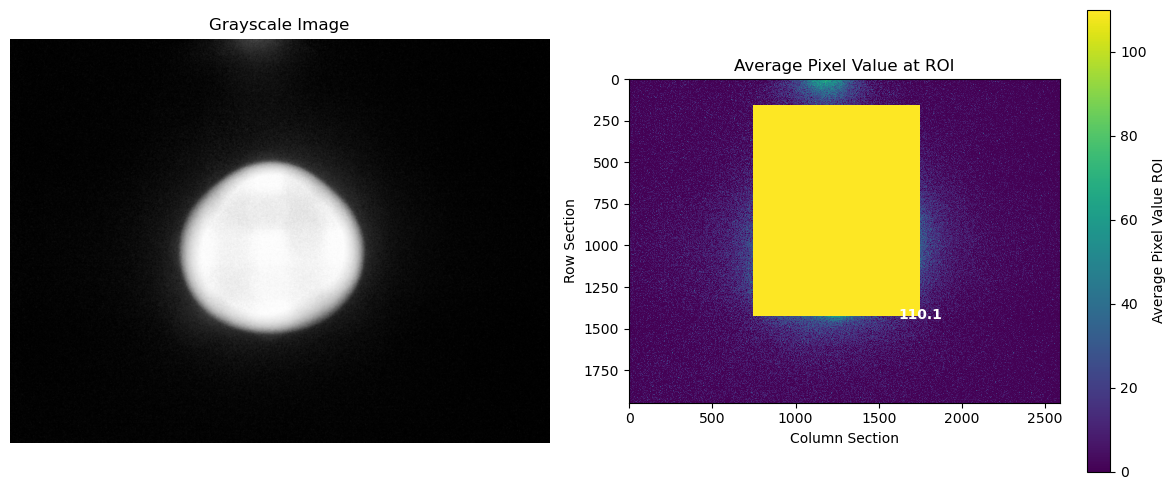

In [12]:
# Use a separate pixel analysis function for ROI images

def pixel_roi_analysis(gray, x, y, w, h, subset=1.0, verbose=True):
    # Calculate overall average
    overall_avg = np.mean(gray)
    if verbose:
        print(f"Overall average pixel value: {overall_avg:.2f}")

    height, width = gray.shape

    if verbose:
        print(f"\nImage dimensions: {width} x {height}")
        print(f"ROI area: Row: {x}:{x+w}, Column: {y}:{y+h}")
        print(f"ROI size: {w} x {h}")

    # Subset dictates percentage of innermost ROI pixels
    subset = subset     # Value between 0 and 1 (fraction of ROI pixels)
    if subset == 1:
        x = x
        y = y
        w = w
        h = h    
    else:
        half_w = w // 2
        add_x = int(half_w * (1 - subset))
        x = x + add_x
        w = int(w * subset)

        half_h = h // 2
        add_y = int(half_h * (1 - subset))
        y = y + add_y
        h = int(h * subset)

    roi_section = gray[y:y+h, x:x+w]
    average_at_roi = np.mean(roi_section)
    std_dev_at_roi = np.std(roi_section)
            
    # Get image with ROI pixels replaced with average
    gray_avg_roi = gray.copy()
    for i in range(y, y + h):
        for j in range(x, x + w):
            gray_avg_roi[i, j] = average_at_roi

    # Display statistics
    if verbose:
        print(f"\Pixel analysis:")
        print(f"Average pixel value at ROI: {average_at_roi:.2f}")
        print(f"Standard deviation at ROI: {std_dev_at_roi:.2f}")

    # Visualize the section averages as a heatmap
    if verbose:
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.imshow(gray, cmap='gray')
        plt.title('Grayscale Image')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(gray_avg_roi, cmap='viridis', interpolation='nearest')
        plt.title('Average Pixel Value at ROI')
        plt.colorbar(label='Average Pixel Value ROI')
        plt.xlabel('Column Section')
        plt.ylabel('Row Section')

        # Add text annotations to show values
        plt.text(j, i, f'{average_at_roi:.1f}', ha='center', va='center', color='white', fontweight='bold')

        plt.tight_layout()
        
        plt.show()

    return overall_avg, average_at_roi

overall_avg, average_at_roi = pixel_roi_analysis(suback_fluog, x, y, w, h, subset=0.8)

Get average pixel value at ROI

In [13]:
print(f"Overall average pixel value: {overall_avg:.2f}")
print(f"Average pixel value at ROI: {average_at_roi:.2f}")

Overall average pixel value: 31.48
Average pixel value at ROI: 110.08


## 3. Test on all fluorescent images (section averages algorithm)

Check first image

Overall average pixel value: 31.48

Image dimensions: 2592 x 1944
Section size: 324 x 324
\Sectioned image analysis:
Min section average: 1.59
Max section average: 244.58
Standard deviation across sections: 63.11


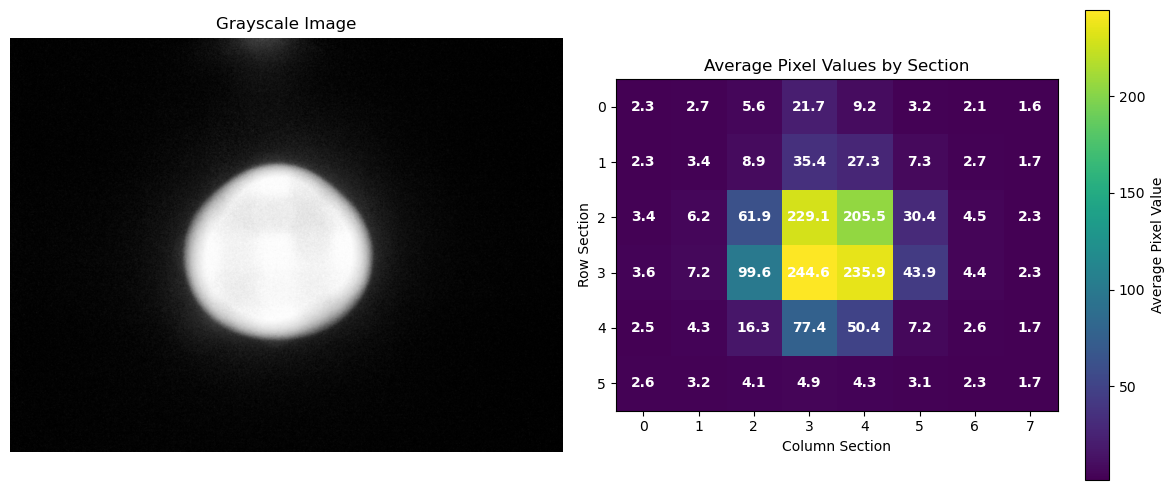

In [ ]:
fluo1 = cv.imread('../AwbOff470/img_full_0000.jpg')
# fluo1g = cv.cvtColor(fluo1, cv.COLOR_BGR2GRAY)
fluo1g = extract_g_channel(fluo1)
suback_fluog1 = subtract_background(fluo1g, background_model)
avg1g, max1g, _, _ = pixel_average_analysis(suback_fluog1, section_rows=6, section_cols=8)

In [15]:
print(f"Average: {avg1g} \nMax: {max1g}")

Average: 31.478768162881675 
Max: 244.5819996951684


Use on last image

Overall average pixel value: 2.45

Image dimensions: 2592 x 1944
Section size: 324 x 324
\Sectioned image analysis:
Min section average: 1.45
Max section average: 11.01
Standard deviation across sections: 1.96


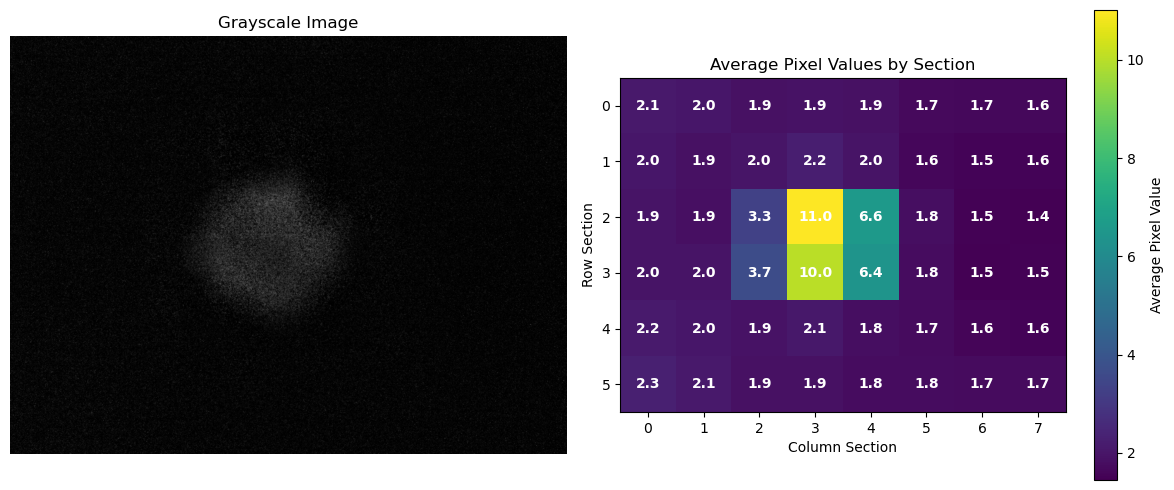

In [ ]:
fluo5 = cv.imread('../AwbOff470/img_full_0007.jpg')
# fluo5g = cv.cvtColor(fluo5, cv.COLOR_BGR2GRAY)
fluo5g = extract_g_channel(fluo5)
suback_fluog5 = subtract_background(fluo5g, background_model)
avg5g, max5g, _, _ = pixel_average_analysis(suback_fluog5, section_rows=6, section_cols=8)

### Perform on all images

In [ ]:
max_list = np.zeros(8)
static_list = np.zeros(8)

for i in range(0, 8):
    fluo = cv.imread(f'../AwbOff470/img_full_{i:04d}.jpg')
    fluo_g = cv.cvtColor(fluo, cv.COLOR_BGR2GRAY)
    # fluo_g = extract_g_channel(fluo)
    suback_fluog = subtract_background(fluo_g, background_model)
    avg, max_val, min_val, static_val = pixel_average_analysis(suback_fluog, section_rows=6, section_cols=8, static_row=3, static_col=3,verbose=False)
    print(f"Image {i}: Average: {avg:.2f}, Max: {max_val:.2f}, Min: {min_val:.2f}, Static: {static_val:.2f}")
    
    max_list[i] = max_val
    static_list[i] = static_val

Image 0: Average: 12.79, Max: 150.11, Min: 1.07, Static: 150.11
Image 1: Average: 12.20, Max: 116.15, Min: 1.45, Static: 116.15
Image 2: Average: 6.93, Max: 66.20, Min: 1.65, Static: 66.20
Image 3: Average: 4.67, Max: 38.00, Min: 1.80, Static: 38.00
Image 4: Average: 4.18, Max: 23.83, Min: 2.07, Static: 23.83
Image 5: Average: 4.49, Max: 19.71, Min: 2.52, Static: 19.71
Image 6: Average: 3.96, Max: 10.69, Min: 2.64, Static: 10.69
Image 7: Average: 3.82, Max: 9.52, Min: 2.71, Static: 9.13


#### Using maximum section averages (MSA)

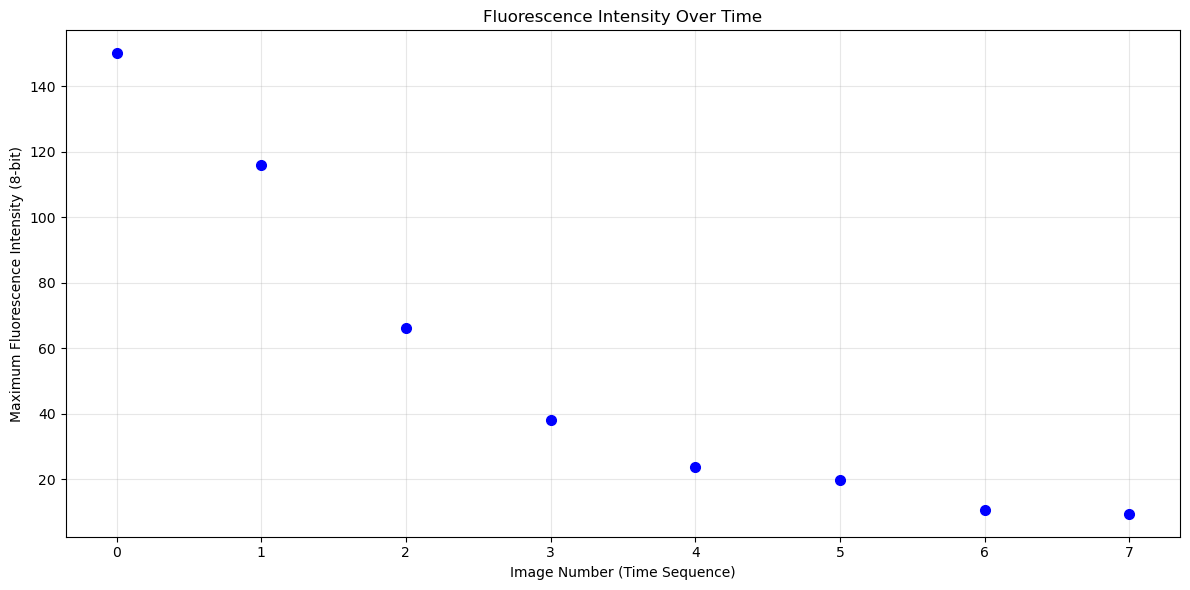

Min: 9.52
Max: 150.11
Range: 140.59


In [24]:
# Create the fluorescence intensity graph
plt.figure(figsize=(12, 6))

image_numbers = list(range(0, len(max_list)))

plt.plot(image_numbers, max_list, 'b-o', linewidth=0, markersize=7)
plt.xlabel('Image Number (Time Sequence)')
plt.ylabel('Maximum Fluorescence Intensity (8-bit)')
plt.title('Fluorescence Intensity Over Time')
plt.grid(True, alpha=0.3)

# mean_intensity = np.mean(max_list)
# std_intensity = np.std(max_list)
# plt.axhline(y=mean_intensity, color='r', linestyle='--', alpha=0.7, label=f'Mean: {mean_intensity:.2f}')
# plt.axhline(y=mean_intensity + std_intensity, color='orange', linestyle=':', alpha=0.7, label=f'+1σ: {mean_intensity + std_intensity:.2f}')
# plt.axhline(y=mean_intensity - std_intensity, color='orange', linestyle=':', alpha=0.7, label=f'-1σ: {mean_intensity - std_intensity:.2f}')

# plt.legend()
plt.tight_layout()
plt.show()

# Print summary statistics
# print(f"\nFluorescence Intensity Statistics:")
# print(f"Mean: {mean_intensity:.2f}")
# print(f"Standard Deviation: {std_intensity:.2f}")
print(f"Min: {min(max_list):.2f}")
print(f"Max: {max(max_list):.2f}")
print(f"Range: {max(max_list) - min(max_list):.2f}")

#### Calculate reference graph

In [27]:
reference_list = calculateReferenceFluorescenceGraph(weakest_value=max_list[7], num_samples=8)

for i in range(len(reference_list)):
    print(f"Reference Sample {i}: {reference_list[i]:.2f}")

Reference Sample 0: 1218.53
Reference Sample 1: 609.26
Reference Sample 2: 304.63
Reference Sample 3: 152.32
Reference Sample 4: 76.16
Reference Sample 5: 38.08
Reference Sample 6: 19.04
Reference Sample 7: 9.52


Show both graphs together

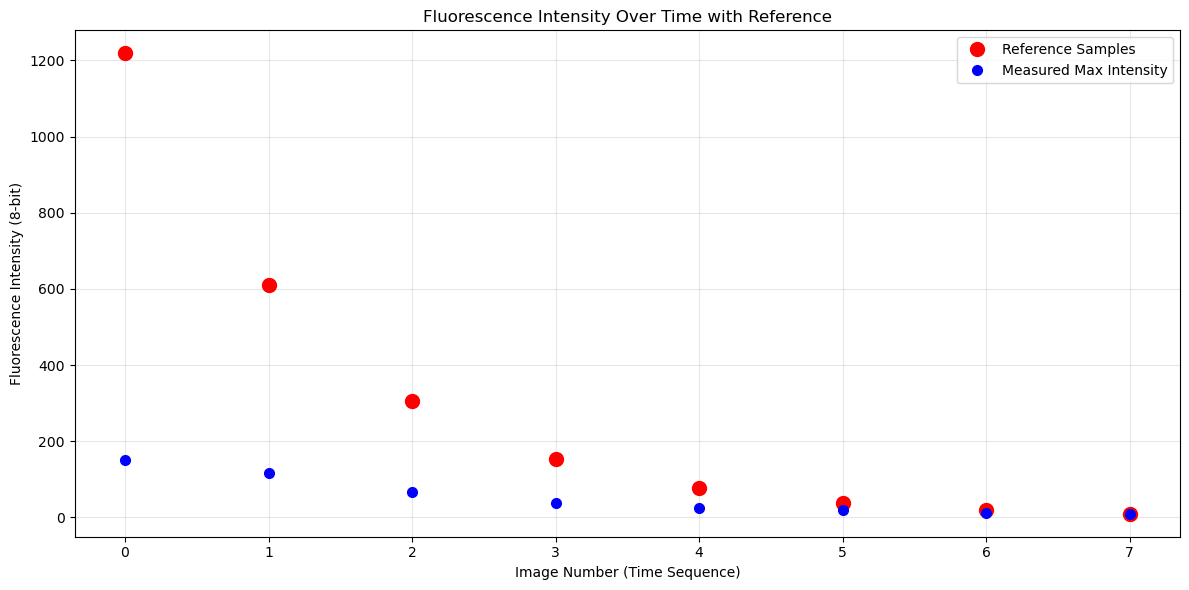

In [28]:
plt.figure(figsize=(12, 6))
image_numbers = list(range(0, len(max_list)))
plt.plot(image_numbers, reference_list, 'ro', linewidth=0, markersize=10)
plt.plot(image_numbers, max_list, 'bo', linewidth=0, markersize=7)
plt.xlabel('Image Number (Time Sequence)')
plt.ylabel('Fluorescence Intensity (8-bit)')
plt.title('Fluorescence Intensity Over Time with Reference')

# Add legend
plt.plot([], [], 'ro', label='Reference Samples', markersize=10)
plt.plot([], [], 'bo', label='Measured Max Intensity', markersize=7)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

#### Using static section averages (SSA)

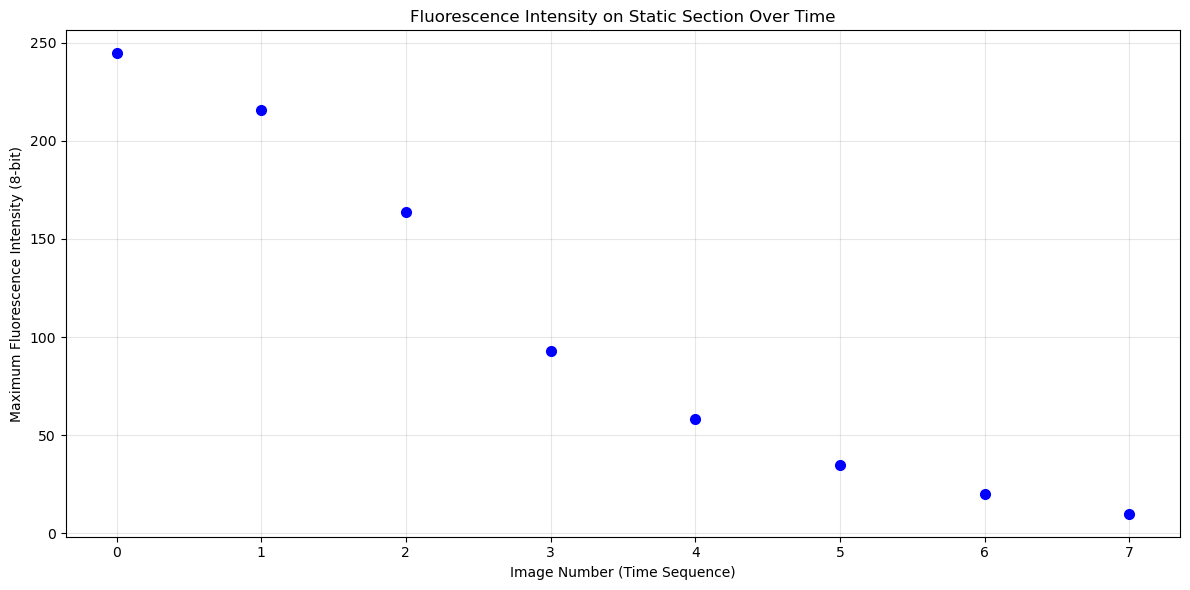

Min: 10.02
Max: 244.58
Range: 234.56


In [20]:
# Create the fluorescence intensity graph
plt.figure(figsize=(12, 6))

image_numbers = list(range(0, len(static_list)))

plt.plot(image_numbers, static_list, 'b-o', linewidth=0, markersize=7)
plt.xlabel('Image Number (Time Sequence)')
plt.ylabel('Maximum Fluorescence Intensity (8-bit)')
plt.title('Fluorescence Intensity on Static Section Over Time')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Min: {min(static_list):.2f}")
print(f"Max: {max(static_list):.2f}")
print(f"Range: {max(static_list) - min(static_list):.2f}")

## 4. Test on all fluorescent images (with bounding box ROI identification)

Found object with bounding box: x=672, y=422, width=1154, height=1105


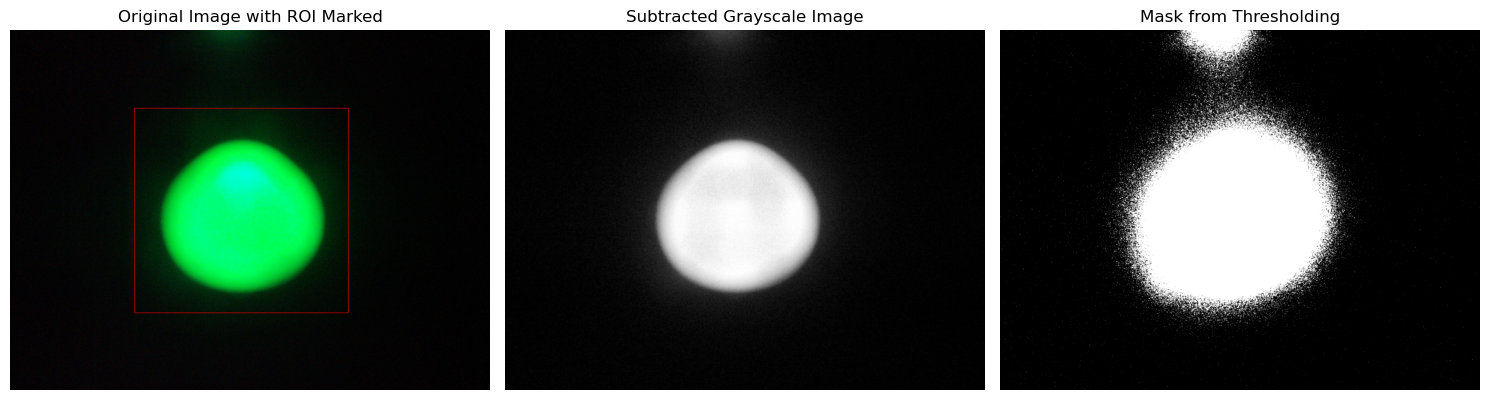

Overall average pixel value: 31.48

Image dimensions: 2592 x 1944
ROI area: Row: 672:1826, Column: 422:1527
ROI size: 1154 x 1105
\Pixel analysis:
Average pixel value at ROI: 241.20
Standard deviation at ROI: 7.48


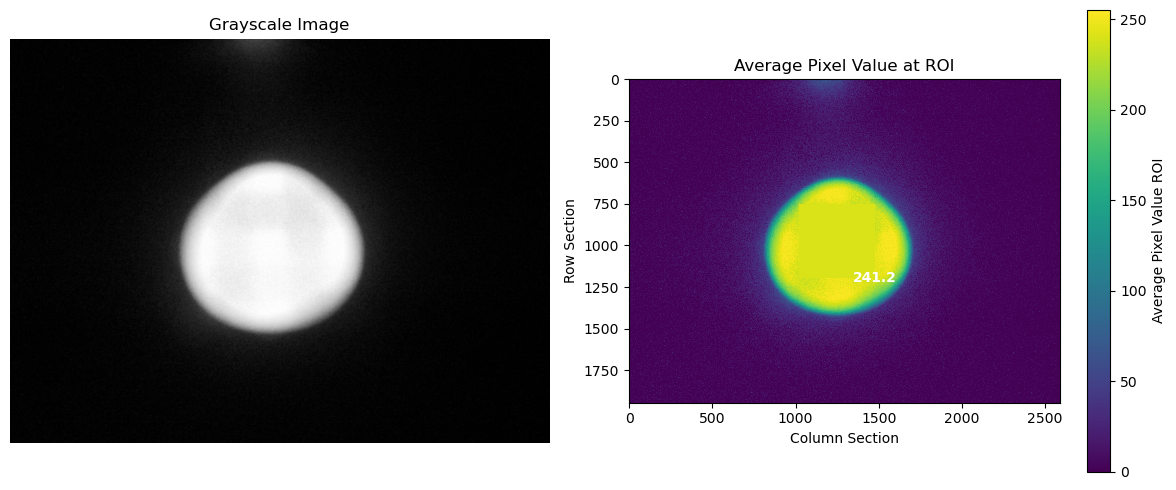

Overall average pixel value: 31.48
Average pixel value at ROI: 241.20


In [ ]:
fluo0 = cv.imread('../AwbOff470/img_full_0000.jpg')
# fluo0g = cv.cvtColor(fluo0, cv.COLOR_BGR2GRAY)
fluo0g = extract_g_channel(fluo0)
suback_fluog0 = subtract_background(fluo0g, background_model)

x, y, w, h = get_roi(fluo0, suback_fluog0, threshold_value=19, verbose=True)
overall_avg, average_at_roi = pixel_roi_analysis(suback_fluog0, x, y, w, h, subset=0.4)
print(f"Overall average pixel value: {overall_avg:.2f}")
print(f"Average pixel value at ROI: {average_at_roi:.2f}")

On last image

Found object with bounding box: x=1208, y=753, width=22, height=19


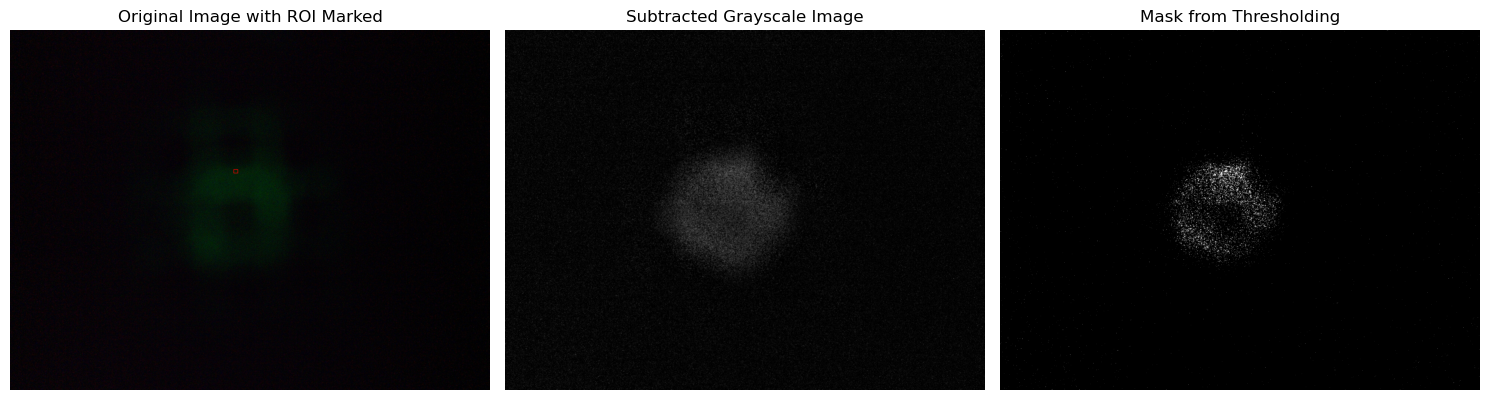

Overall average pixel value: 2.45

Image dimensions: 2592 x 1944
ROI area: Row: 1208:1230, Column: 753:772
ROI size: 22 x 19
\Pixel analysis:
Average pixel value at ROI: 23.73
Standard deviation at ROI: 7.95


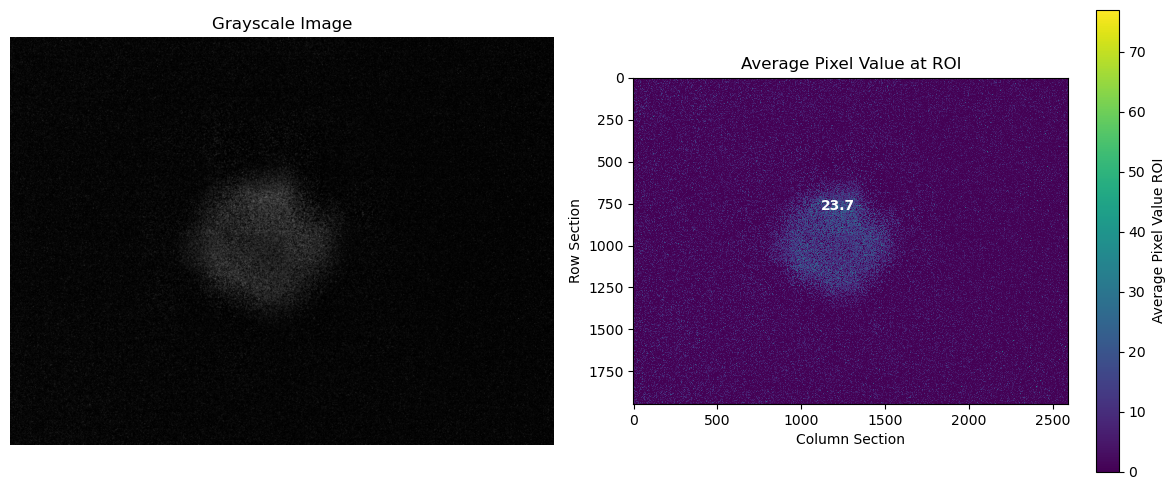

Overall average pixel value: 2.45
Average pixel value at ROI: 23.73


In [ ]:
fluo5 = cv.imread('../AwbOff470/img_full_0007.jpg')
fluo5g = extract_g_channel(fluo5)
suback_fluog5 = subtract_background(fluo5g, background_model)
x5, y5, w5, h5 = get_roi(fluo5, suback_fluog5, threshold_value=19, verbose=True)
overall_avg5, average_at_roi5 = pixel_roi_analysis(suback_fluog5, x5, y5, w5, h5, subset=0.4)
print(f"Overall average pixel value: {overall_avg5:.2f}")
print(f"Average pixel value at ROI: {average_at_roi5:.2f}")

Perform on all images

In [ ]:
avg_roi_arr = np.zeros(8)

for i in range(0, 8):
    fluo = cv.imread(f'../AwbOff470/img_full_{i:04d}.jpg')
    fluo_g = cv.cvtColor(fluo, cv.COLOR_BGR2GRAY)
    suback_fluog = subtract_background(fluo_g, background_model)

    x, y, w, h = get_roi(fluo, suback_fluog, threshold_value=14, verbose=False)
    overall_avg, average_at_roi = pixel_roi_analysis(suback_fluog, x, y, w, h, subset=0.4, verbose=False)
    print(f"Image {i}: Average: {overall_avg:.2f}, ROI average: {average_at_roi:.2f}")
    
    avg_roi_arr[i] = average_at_roi

Image 0: Average: 20.21, ROI average: 151.17
Image 1: Average: 15.58, ROI average: 138.34
Image 2: Average: 9.81, ROI average: 104.62
Image 3: Average: 7.78, ROI average: 60.49
Image 4: Average: 5.39, ROI average: 35.95
Image 5: Average: 3.93, ROI average: 21.76
Image 6: Average: 3.30, ROI average: 15.14
Image 7: Average: 2.82, ROI average: 18.11


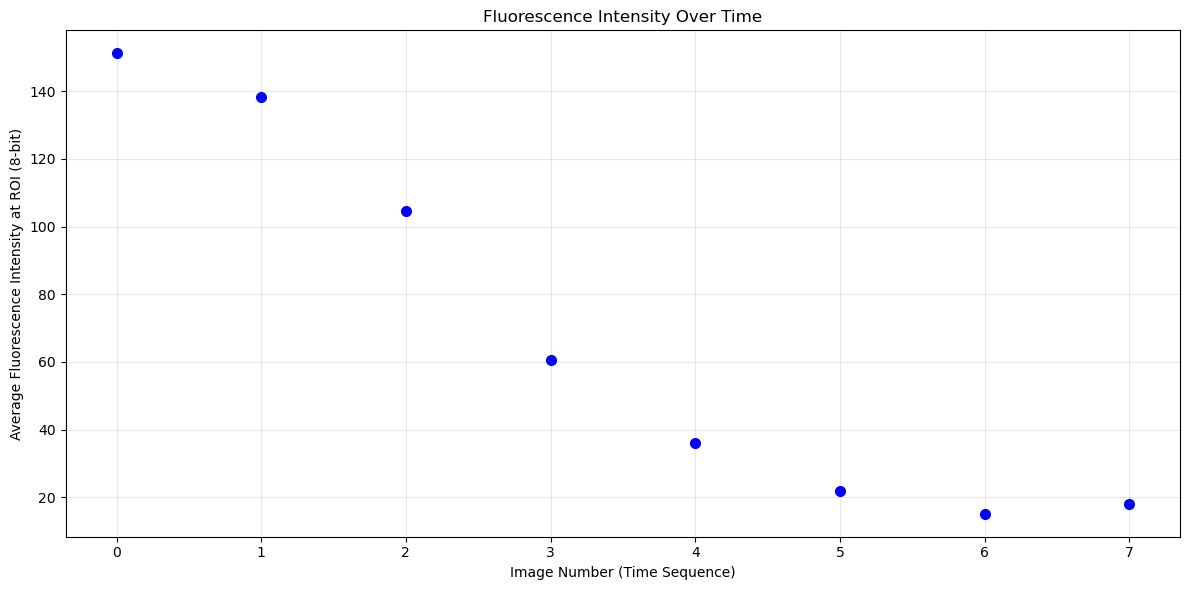

Min: 15.14
Max: 151.17
Range: 136.02


In [26]:
# Create the fluorescence intensity graph
plt.figure(figsize=(12, 6))

image_numbers = list(range(0, len(avg_roi_arr)))  

plt.plot(image_numbers, avg_roi_arr, 'b-o', linewidth=0, markersize=7)
plt.xlabel('Image Number (Time Sequence)')
plt.ylabel('Average Fluorescence Intensity at ROI (8-bit)')  # Also fixed label
plt.title('Fluorescence Intensity Over Time')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Also fix the summary statistics to use avg_roi_arr
print(f"Min: {min(avg_roi_arr):.2f}")
print(f"Max: {max(avg_roi_arr):.2f}")
print(f"Range: {max(avg_roi_arr) - min(avg_roi_arr):.2f}")